<h1 class="header"><img class="logo" src="../images/socib_logo.png" width="200px"></h1>

<h3> STYLING NOTEBOOK (OPTIONAL)</h3>

In [1]:
from IPython.core.display import HTML
import urllib
HTML(urllib.urlopen('https://raw.githubusercontent.com/socib/API_examples/master/style/custom/custom.css').read())

<h3> HANDY PYTHON PACKAGES </h3>

In [2]:
import requests
import json
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
from json2html import *
from IPython.display import HTML, display
from matplotlib import colors
import shapely
from shapely.geometry import box
%matplotlib inline

<h3> PREREQUISITES </h3>

In [3]:
api_key = '' #write you SOCIB api_key
api_url = 'http://api.socib.es'
headers = {
    'accept': 'application/vnd.socib+json',
    'apikey': api_key,
}

<h3> REQUESTING A DATA-SOURCE'S DATA </h3>

Let's look for active deployments during a certain time range in a defined area, involving a certain platform type and measuring a certain variable:

In [4]:
time_range_start = '2014-07-01T00:00:00' # should match the notation YYYY-MM-DDTHH:MM:SS
time_range_end =  '2014-12-01T00:00:00' # should match the notation YYYY-MM-DDTHH:MM:SS
platform_type = 'Surface drifter'
variables = 'sea_water_temperature'

In [5]:
min_lat = 40.0#float
max_lat = 38.0 #float
min_lon = 0.0 #float
max_lon = 3.0#float
bbox = str(min_lat)+','+str(max_lat)+','+str(min_lon)+','+str(max_lon)

In [6]:
end_point = '/data-sources/'
url_addons = '?platform_type=%s&initial_datetime=%s&end_datetime=%s&standard_variable=%s&bbox=%s'%(platform_type,time_range_start,time_range_end, variables,bbox)
request = requests.get('%s%s%s' % (api_url, end_point,url_addons), headers=headers)
response = json.loads(request.text)
print('Requested url: '+'%s%s%s' % (api_url, end_point,url_addons))
print(" ")
print('A total of %s SOCIB deployments match the above searching criteria'% (response['count']))

Requested url: http://api.socib.es/data-sources/?platform_type=Surface drifter&initial_datetime=2014-07-01T00:00:00&end_datetime=2014-12-01T00:00:00&standard_variable=sea_water_temperature&bbox=40.0,38.0,0.0,3.0
 
A total of 53 SOCIB deployments match the above searching criteria


Let's have a look to the metadata of one of the above deployments:

In [7]:
targeted_deployment = response['results'][4]#i.e deployment/data-source number 4 of the above page
metadata = {k:v for k, v in targeted_deployment.items() if k != 'entries'} #skipping the deployment data for later
HTML(json2html.convert(json=metadata))

From [What is a data-source?](what_is_a_data_source.ipynb) we know how to download, access and explore a given data-source/deployment netCDFs (by using THREDDS services available for the so-called entries) but in case of users that prefer to overlook the underlying data format, SOCIB API offers an auxiliary endpoint: the <b>/data-sources/{id}/data</b>.<br> Let's request the above data-source data:

In [8]:
end_point_plus_aux = '/data-sources/'+targeted_deployment['id']+'/data/'
request = requests.get('%s%s' % (api_url, end_point_plus_aux), headers=headers)
response = json.loads(request.text)
print('Requested url: '+'%s%s. Be aware of the id requested' % (api_url, end_point_plus_aux))

Requested url: http://api.socib.es/data-sources/e70d027340/data/. Be aware of the id requested


<h3>EXPLORING THE <span>/DATA-SOURCES/{ID}/DATA</span> AUXILIARY ENDPOINT</h3>

In [9]:
def get_data_overview(response):
    #provides a quick glimse of a data-source variables overlooking its data values
    variable_metadata = {} 
    for level in response.keys():
        variable_metadata[level] = {}
        for item in response[level]['feature_types']:
            variable_metadata[level][item['feature_type']] = {}
            for standard_name in item['variables'].keys():
                variable_metadata[level][item['feature_type']][standard_name] = {}
                for var in item['variables'][standard_name].keys():
                    variable_metadata[level][item['feature_type']][standard_name][var] = {}
                    for key,value in item['variables'][standard_name][var].items():
                        if key != 'data':#overlooking data values
                            variable_metadata[level][item['feature_type']][standard_name][var][key] = value
    return variable_metadata

In [10]:
def get_coordinates_overview(response):
    #provides a quick glimse of a data-source coordinates overlooking its data values
    coordinates_metadata = {} 
    for level in response.keys():
        coordinates_metadata[level] = {}
        for item in response[level]['feature_types']:
            coordinates_metadata[level][item['feature_type']] = {}
            for standard_name in item['coordinates'].keys():
                coordinates_metadata[level][item['feature_type']][standard_name] = {}
                for key,value in item['coordinates'][standard_name].items():
                    if key != 'data':#overlooking data values
                        coordinates_metadata[level][item['feature_type']][standard_name][key] = value
    return coordinates_metadata

Let's have a look to the available variables in the above data-source data:

In [11]:
display(HTML(json2html.convert(json=get_data_overview(response))))

Variables are grouped by:
<ul>
<li>processing levels: see all posible processing levels at [Quick start](../tips/quick_start.ipynb) </li>
<li>feature type : see all posible feature types at [Quick start](..tips/quick_start.ipynb) </li>
<li>standard name: see all posible processing standard names at [Quick start](..tips/quick_start.ipynb).<br> Be aware that when unknown standard name, they are grouped in '_NONE_'</li>
</ul>

For each of the above variables you have also access to the coordinates:

In [12]:
display(HTML(json2html.convert(json=get_coordinates_overview(response))))

<h3>FOCUSING ON A SPECIFIC VARIABLE - <span> REQUESTING A CERTAIN VARIABLE DATA </span> </h3>

As already shown in ['Searching for_certain data-sources'](searching_for_certain_data_sources.ipynb), there are parameters that added to an endpoint allows applying some filtering over the generic answer. In case of the <b>/data-sources/{id}/data</b> auxiliary endpoint we can, for example, restrict the generic answer (above) to a specific variable:

In [13]:
variables = 'sea_water_temperature'
end_point_plus_aux = '/data-sources/'+targeted_deployment['id']+'/data/'
url_addons = '?standard_variable=%s'%(variables)
request = requests.get('%s%s%s' % (api_url, end_point_plus_aux,url_addons), headers=headers)
response = json.loads(request.text)
print('Requested url: '+'%s%s%s' % (api_url, end_point_plus_aux, url_addons))

Requested url: http://api.socib.es/data-sources/e70d027340/data/?standard_variable=sea_water_temperature


In [14]:
display(HTML(json2html.convert(json=get_data_overview(response))))

It is possible to narrow down even more and request the above variable from a specific procesing level:

In [15]:
variables = 'sea_water_temperature'
level = 'L1'
end_point_plus_aux = '/data-sources/'+targeted_deployment['id']+'/data/'
url_addons = '?standard_variable=%s&processing_level=%s'%(variables, level)
request = requests.get('%s%s%s' % (api_url, end_point_plus_aux,url_addons), headers=headers)
response = json.loads(request.text)
print('Requested url: '+'%s%s%s' % (api_url, end_point_plus_aux, url_addons))

Requested url: http://api.socib.es/data-sources/e70d027340/data/?standard_variable=sea_water_temperature&processing_level=L1


In [16]:
display(HTML(json2html.convert(json=get_data_overview(response))))

<h3><span>PLOTTING THE DATA RETOURNED</span> BY THE /DATA-SOURCES/{ID}/DATA AUXILIARY ENDPOINT </h3>

In [17]:
def get_matching_params(param, response):
    #returns matching params
    params = [] 
    for level in response.keys():
        for item in response[level]['feature_types']:
            for standard_name in item['variables'].keys():
                for var in item['variables'][standard_name].keys():
                    if var == param:
                        try:
                            params.append({'units':item['variables'][standard_name][var]['units'], 'data': item['variables'][standard_name][var]['data'], 'level': level, 'standard_name': standard_name, 'feature': item['feature_type'], 'name': param})
                        except:
                            params.append({'units': '-', 'data': item['variables'][standard_name][var]['data'], 'level': level, 'standard_name': standard_name, 'feature': item['feature_type'], 'name': param})
    return params

In [18]:
def get_matching_coords(coord, response):
    #returns matching coords
    coords = [] 
    for level in response.keys():
        for item in response[level]['feature_types']:
            for standard_name in item['coordinates'].keys():
                if standard_name == coord:
                    try:
                        coords.append({'units':item['coordinates'][standard_name]['units'], 'data': item['coordinates'][standard_name]['data'], 'level': level, 'standard_name': standard_name, 'feature': item['feature_type']})
                    except:
                        coords.append({'units': '-', 'data': item['coordinates'][standard_name]['data'], 'level': level, 'standard_name': standard_name, 'feature': item['feature_type']})
    return coords

In [19]:
params = get_matching_params('WTEM', response)
display(HTML(json2html.convert(json=[{k:v for k,v in param.items() if k!= 'data'} for param in params])))

units,feature,standard_name,name,level
C,trajectory,sea_water_temperature,WTEM,L1


In [20]:
latitudes = get_matching_coords('latitude', response)
display(HTML(json2html.convert(json=[{k:v for k,v in lat.items() if k!= 'data'} for lat in latitudes])))

units,standard_name,feature,level
degrees_north,latitude,trajectory,L1


In [21]:
longitudes = get_matching_coords('longitude', response)
display(HTML(json2html.convert(json=[{k:v for k,v in lon.items() if k!= 'data'} for lon in longitudes])))

units,standard_name,feature,level
degrees_east,longitude,trajectory,L1


Choosing the only matching param on the list:

In [22]:
var_values = np.array(params[0]['data'],dtype=float)
lat_values = np.array(latitudes[0]['data'],dtype=float)
lon_values = np.array(longitudes[0]['data'],dtype=float)

In [23]:
var_units = params[0]['units']
var_std_name = params[0]['standard_name']
var_name = params[0]['name']

Plot overall trajectory:

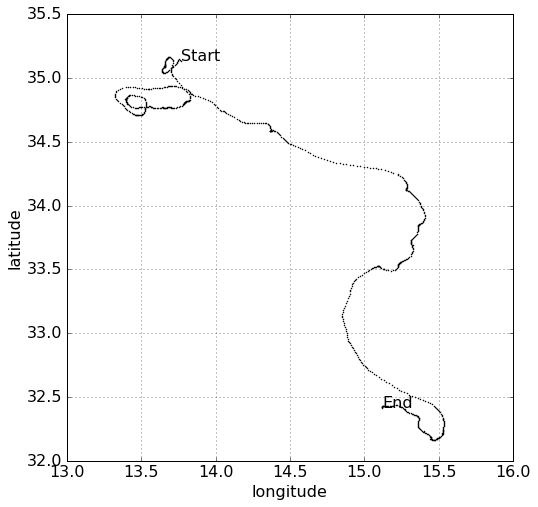

In [24]:
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
plt.plot(lon_values, lat_values, 'ko', ms=1)
plt.text(lon_values[0], lat_values[0], 'Start', fontsize=16)
plt.text(lon_values[-1], lat_values[-1], 'End', fontsize=16)

plt.grid()
plt.ylabel('latitude', fontsize=16)
plt.xlabel('longitude', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.show()

Broader view:

In [25]:
lonmin, lonmax = ax.get_xlim()
latmin, latmax = ax.get_ylim()
cmap = plt.cm.Spectral_r
norm = colors.Normalize(vmin=min(var_values), vmax=max(var_values))

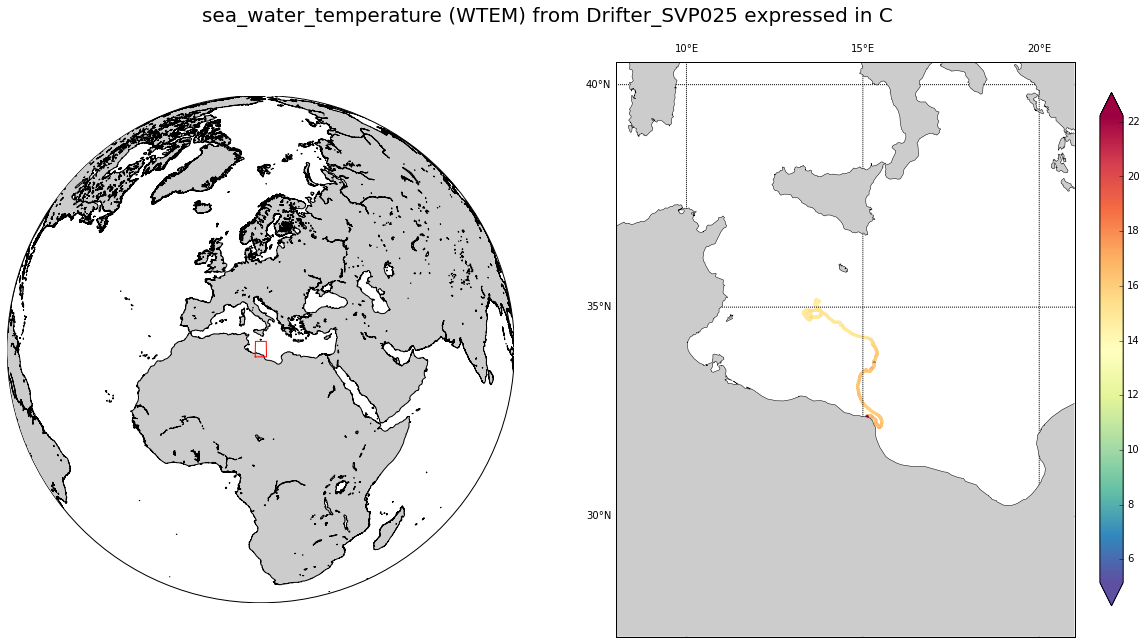

In [26]:
fig = plt.figure(figsize=(20,20))

#rigth plot
ax = fig.add_subplot(122)
m = Basemap(projection='merc', llcrnrlat=latmin-5, urcrnrlat=latmax+5,llcrnrlon=lonmin-5, urcrnrlon=lonmax+5, lat_ts=20, resolution='i')
lon2, lat2 = m(lon_values, lat_values)
m.scatter(lon2, lat2, s=10, c=var_values, edgecolor='None', cmap=cmap, norm=norm)
m.drawcoastlines(linewidth=0.5, zorder=3)
m.fillcontinents(zorder=2)
m.drawparallels(np.arange(-90.,91.,5.), labels=[1,0,0,0], zorder=1)
m.drawmeridians(np.arange(-180.,181.,5.), labels=[0,0,1,0], zorder=1)
plt.colorbar(fraction=0.046, extend='both', cmap=cmap, norm=norm)

#left plot
ax = fig.add_subplot(121)
bounding_box = shapely.geometry.box(lonmin, latmin, lonmax, latmax)
x = bounding_box.centroid.x
y = bounding_box.centroid.y
map = Basemap(projection='ortho',lat_0=y, lon_0=x,resolution='i')
map.drawmapboundary()
map.fillcontinents()
map.drawcoastlines()
xs = [lonmin,lonmax,lonmax,lonmin,lonmin]
ys = [latmin,latmin,latmax,latmax,latmin]
map.plot(xs, ys,latlon = True, color='red')

plt.suptitle(var_std_name +' ('+var_name+') from '+metadata['platform']['name']+' expressed in '+var_units, fontsize=20, y=0.75)
plt.show()

<h3> WHAT ELSE?</h3>

<ul>
<li><b>SUBSETTING A DATA-SOURCE'S DATA</b> <br><br>If you want to know more about how to subset a given data-source's data overlooking the netCDF format, please have a look at the [Example 4](subsetting_a_data_sources_data.ipynb) ('Subsetting a data-source's data'), where it is explained how to use query parameters over the API auxiliary endpoints to subset a deployments data.</li>
<br>
<li><b>RESAMPLING A DATA-SOURCE'S DATA</b> <br><br>If you want to know more about how to resample a given data-source's data overlooking the netCDF format, please have a look at the [Example 5](resampling_a_data_sources_data.ipynb) ('Resampling a data-source's data'), where it is explained how to use query parameters over the API auxiliary endpoints to resample a deployments data.</li>
</ul>